In [49]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '5,6'
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5,6"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [50]:
# Using seaborn for pairplot.
!pip install -q seaborn
!pip install xgboost

In [51]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [52]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [53]:
# Defining columns to use
columns_to_use = ["global_x", "global_y", "v_vel", "v_acc"] #using just 4 of them

# Defining chunk size for reading data
chunk_size = 100

# Initializing an empty list to store data chunks
data_chunks = []

for chunk in pd.read_csv("https://data.transportation.gov/resource/8ect-6jqj.csv", 
                         chunksize=chunk_size, usecols=columns_to_use):
    data_chunks.append(chunk)

# Concatenate data chunks into a single DataFrame
velocity_dataset = pd.concat(data_chunks, ignore_index=True)

In [54]:
v_dataset = velocity_dataset.copy()
v_dataset.tail()

,global_x,global_y,v_vel,v_acc
995,2230522.629,1375574.155,0.0,0.0
996,2230522.629,1375574.155,0.0,0.0
997,2230522.629,1375574.155,0.0,0.0
998,2230522.629,1375574.155,0.0,0.0
999,2230522.629,1375574.155,0.0,0.0


In [55]:
# Define input features and labels (trying an alternate method: using train_test_split form sklearn)
input_features = ["global_x", "global_y", "v_acc"]
output_labels = ["v_vel"]

# Split dataset into input features and labels
X = v_dataset[input_features]
Y = v_dataset[output_labels]

# Split the dataset into training and test sets (80-20 split)
train_features, test_features, train_labels, test_labels = train_test_split(X, Y, test_size=0.2, random_state=42)

# Print the shape of training and test sets
print("Train Features Shape:", train_features.shape)
print("Train Labels Shape:", train_labels.shape)
print("Test Features Shape:", test_features.shape)
print("Test Labels Shape:", test_labels.shape)

Train Features Shape: (800, 3)
Train Labels Shape: (800, 1)
Test Features Shape: (200, 3)
Test Labels Shape: (200, 1)


In [56]:
feature_normalizer = tf.keras.layers.Normalization(axis=-1)
feature_normalizer.adapt(np.array(train_features))
print(feature_normalizer.mean.numpy())

[[2230521.8   1375565.2        -0.237]]


In [57]:
normalized_train_features = feature_normalizer(train_features)
normalized_test_features = feature_normalizer(test_features)

In [58]:
# Initialize and train the XGBoost Regressor
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)

In [59]:
%%time
xgb_model.fit(normalized_train_features, train_labels.values.ravel())

CPU times: user 1h 53min 39s, sys: 5.35 s, total: 1h 53min 44s
Wall time: 1min 39s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [46]:
# Predict on the test set
test_predictions = xgb_model.predict(normalized_test_features)

# Evaluate the model
mae = mean_absolute_error(test_labels, test_predictions)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 4.283664658088237


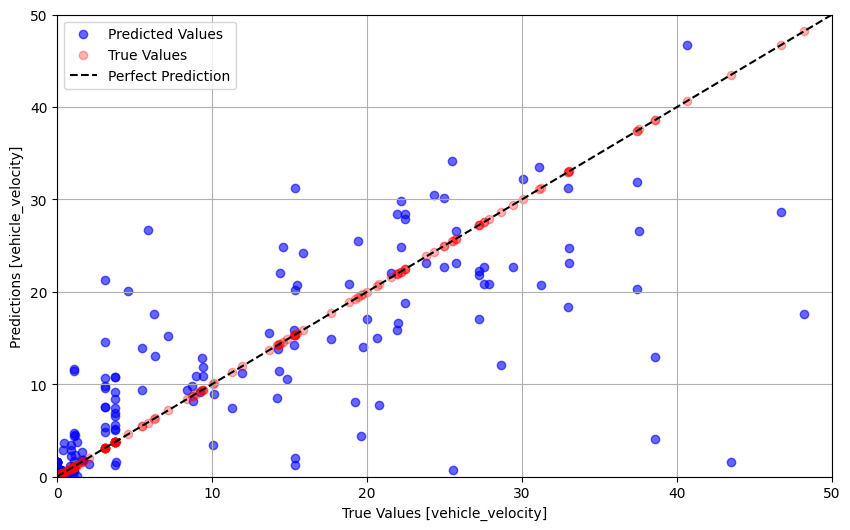

In [47]:
# Plot the predictions vs. true values
plt.figure(figsize=(10, 6))
plt.scatter(test_labels, test_predictions, color='blue', label='Predicted Values', alpha=0.6)
plt.scatter(test_labels, test_labels, color='red', label='True Values', alpha=0.3)  # True values for comparison
plt.xlabel('True Values [vehicle_velocity]')
plt.ylabel('Predictions [vehicle_velocity]')
plt.legend()
plt.grid(True)
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
plt.plot(lims, lims, 'k--', label='Perfect Prediction')  # Diagonal line for perfect prediction
plt.legend()
plt.show()

In [48]:
def predict_and_compare(index):
    inp_features = np.array([test_features.iloc[index]])
    
    true_label = test_labels.iloc[index].values[0]
    
    predicted_label = xgb_model.predict(inp_features)
    
    error = abs(true_label - predicted_label) # Calculating the absolute error
    
    print(f"Input Features: {inp_features}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print(f"Error (absolute difference): {error}")


index_to_check = 170
predict_and_compare(index_to_check)

Input Features: [[2230503.104 1375563.801       4.29 ]]
True Label: 31.07
Predicted Label: [26.828]
Error (absolute difference): [4.242]
